In [4]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pylab as plt
import pandas as pd
import h5py
from scipy.stats import wasserstein_distance as w_d
import pickle

plt.rcParams['font.size'] = 18


In [2]:
file_path = '/global/cfs/cdirs/m4236/cosmosweb/catalogs/hsc_jwst_matched_with_images_high_snr'
f = h5py.File(file_path, 'r')

list(f.keys())


['Confidence_level',
 'bulge_radius',
 'dec',
 'dec_specz',
 'disk_radius',
 'flux_err-cal_model_cfht-u',
 'flux_err-cal_model_f115w',
 'flux_err-cal_model_f150w',
 'flux_err-cal_model_f277w',
 'flux_err-cal_model_f444w',
 'flux_err-cal_model_hsc-g',
 'flux_err-cal_model_hsc-i',
 'flux_err-cal_model_hsc-r',
 'flux_err-cal_model_hsc-y',
 'flux_err-cal_model_hsc-z',
 'flux_model_cfht-u',
 'flux_model_f115w',
 'flux_model_f150w',
 'flux_model_f277w',
 'flux_model_f444w',
 'flux_model_hsc-g',
 'flux_model_hsc-i',
 'flux_model_hsc-r',
 'flux_model_hsc-y',
 'flux_model_hsc-z',
 'hsc_images',
 'id_specz_khostovan25',
 'jwst_images',
 'lephare_photozs',
 'lp_age',
 'lp_mass',
 'lp_sfr',
 'lp_ssfr',
 'lp_type',
 'lp_zpdf_l68',
 'lp_zpdf_u68',
 'mag_model_cfht-u',
 'mag_model_f115w',
 'mag_model_f150w',
 'mag_model_f277w',
 'mag_model_f444w',
 'mag_model_hsc-g',
 'mag_model_hsc-i',
 'mag_model_hsc-r',
 'mag_model_hsc-y',
 'mag_model_hsc-z',
 'photoz',
 'ra',
 'ra_specz',
 'specz']

In [5]:
# model_name = 'convnext'
# model_sizes = ['tiny', 'small', 'base', 'large']
# model_name = 'vit'
# model_sizes = ['base_16', 'large_16', 'huge_14']
# model_name = 'dino'
# model_sizes = ['s_14', 'b_14', 'l_14', 'g_14']
model_name = 'astroPT'
model_sizes = ['015M', '095M', '850M']
n = 5000
telescope = 'hsc'
upsampled = True

dir_out = '/pscratch/sd/a/ashodkh/platonic_universe/embeddings/'

embeddings = {}

for model_size in model_sizes:
    if upsampled:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.npy')
    else:
        embeddings[model_size] = np.load(dir_out + f'embeddings_{telescope}_{n}_convnext{model_size}.npy')


if model_name == 'astroPT':
    with open(dir_out + f'features_{telescope}_{n}_{model_name}_{model_size}_upsampled_images.pkl', 'rb') as pickle_f:
        features = pickle.load(pickle_f)
        

In [6]:
nns = {}
k = 30
for model_size in model_sizes:
    nns[model_size] = NearestNeighbors(n_neighbors=k, metric="minkowski").fit(embeddings[model_size]).kneighbors(return_distance=False)
    

In [7]:
params = ['mag_model_hsc-g', 'lp_mass', 'lp_ssfr', 'lephare_photozs']
#params = ['mag_model_f150w', 'lp_mass', 'lp_ssfr', 'lephare_photozs']

w_d_mean = {}
comparison_names = []
for m, model_size in enumerate(model_sizes[:-1]):
    comparison_names.append(model_size + ' vs. ' + model_sizes[m+1])

for j, param in enumerate(params):
    print(param)
    w_d_mean[param] = {}
    if model_name == 'astroPT':
        param_arr = features[param]
    else:
        param_arr = f[param][:n]
    for m, model_size in enumerate(model_sizes[:-1]):
        w_ds = [w_d(param_arr[nns[model_size][ind]], param_arr[nns[model_sizes[m+1]][ind]]) for ind in range(n)]
        w_d_mean[param][comparison_names[m]] = np.mean(w_ds)
        print(comparison_names[m] + f' w_d={np.mean(w_ds)}')
        

mag_model_hsc-g
015M vs. 095M w_d=0.20677732613881425
095M vs. 850M w_d=0.1653189284515381
lp_mass
015M vs. 095M w_d=0.1345558811569214
095M vs. 850M w_d=0.12891699003537496
lp_ssfr
015M vs. 095M w_d=0.2433114062976837
095M vs. 850M w_d=0.2348529778067271
lephare_photozs
015M vs. 095M w_d=0.14931202093280543
095M vs. 850M w_d=0.12978374803792064


In [8]:
comparison_names

['015M vs. 095M', '095M vs. 850M']

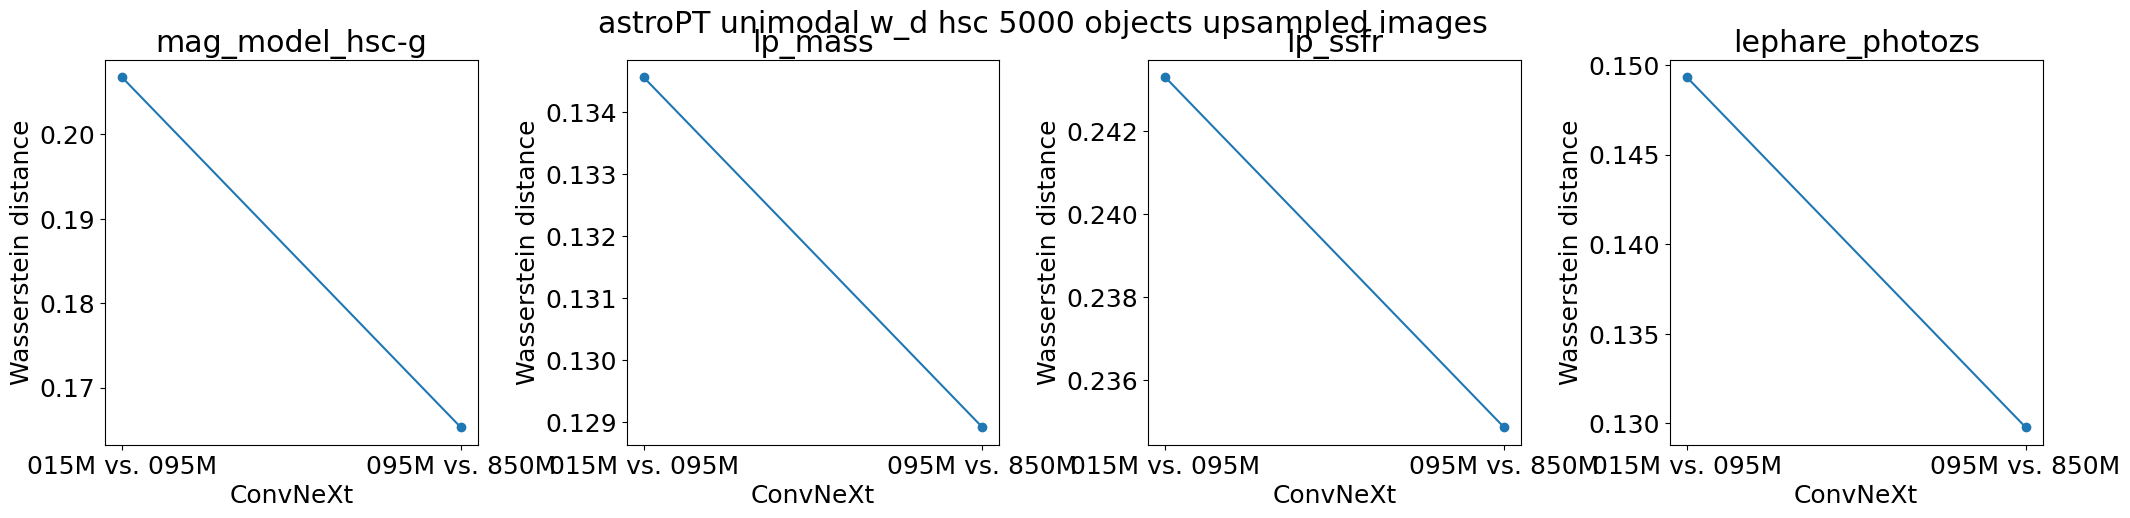

In [9]:
fig, ax = plt.subplots(ncols=len(params), figsize=(25,5))
fig.subplots_adjust(wspace=0.4)

for j, param in enumerate(params):
    ax[j].plot(np.arange(len(comparison_names)), [w_d_mean[param][k] for k in comparison_names], 'o-', label='wasserstein distance mean')
    ax[j].set_title(param)
    ax[j].set_xlabel('ConvNeXt')
    ax[j].set_ylabel('Wasserstein distance')
    ax[j].set_xticks(np.arange(len(comparison_names)))
    ax[j].set_xticklabels(list(w_d_mean[param].keys()))

if upsampled:
    fig.suptitle(f'{model_name} unimodal w_d {telescope} {n} objects upsampled images')
    plt.savefig(f'{model_name}_unimodal_w_d_{telescope}_{n}_upsampled_images.png', bbox_inches='tight')
else:
    fig.suptitle(f'{model_name} unimodal w_d {telescope} {n} objects')
    plt.savefig(f'{model_name}_unimodal_w_d_{telescope}_{n}.png', bbox_inches='tight')
